In [ ]:
## This notebook, along with several import functions used in it are adapted from Insight Software Consortium, Image Registration Introduction
# https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/R_html/60_Registration_Introduction.html


import SimpleITK as sitk
import os
# Enable display of HTML.
from IPython.display import display, HTML

# Plots will be inlined.
%matplotlib inline

# Callbacks for plotting registration progress.
import registration_callbacks

import numpy as np 
import re
from registration_utilities import save_transform_and_image, load_data

## Loading Data, paths definition


In [14]:
# path to store final results 
OUTPUT_DIR = "/Users/marijapajdakovic/Desktop/burr_hole_project/results/registration/correlation"
os.makedirs(OUTPUT_DIR, exist_ok=True)
# used for testing purposes on individual images
OUTPUT_DIR_TEST = "/Users/marijapajdakovic/Desktop/burr_hole_project/results/registration/"

# directory path to the whole dataset
# path to the dataset containing the clipped images 
DATA_DIR_PATH = "/Users/marijapajdakovic/Desktop/burr_hole_project/results/window_clipping"
preop, postop = load_data(DATA_DIR_PATH)


# for testing purposes, one image only
fixed_image = sitk.ReadImage("/Users/marijapajdakovic/Desktop/burr_hole_project/results/window_clipping/18_preop_clipped.nii.gz", sitk.sitkFloat32)
moving_image = sitk.ReadImage("/Users/marijapajdakovic/Desktop/burr_hole_project/results/window_clipping/18_postop_clipped.nii.gz", sitk.sitkFloat32)


## Initial Alignment, single image case

A reasonable guesstimate for the initial translational alignment can be obtained by using
the CenteredTransformInitializer (functional interface to the CenteredTransformInitializerFilter). 

The resulting transformation is centered with respect to the fixed image and the
translation aligns the centers of the two images. 

Two things to note about this filter, it requires the fixed and moving image 
have the same type even though it is not algorithmically required, and its
return type is the generic SimpleITK.Transform.

In [15]:
from registration_utilities import initial_alignment

initial_transform = initial_alignment(fixed_image, moving_image)


## Final registration

### Single image case, testing 

Try transform on one image pair only.



In ITK v4 the registration method accepts three transformations (if you look at the diagram above you will only see two transformations, Moving transform represents $T_{opt} \circ T_m$):
<ul>
<li>
SetInitialTransform, $T_{opt}$ - composed with the moving initial transform, maps points from the virtual image domain to the moving image domain, modified during optimization. 
</li>
<li>
SetFixedInitialTransform $T_f$- maps points from the virtual image domain to the fixed image domain, never modified.
</li>
<li>
SetMovingInitialTransform $T_m$- maps points from the virtual image domain to the moving image domain, never modified.
</li>
</ul>

The transformation that maps points from the fixed to moving image domains is thus: $^M\mathbf{p}  = T_{opt}(T_m(T_f^{-1}(^F\mathbf{p})))$

We now modify the previous example to use $T_{opt}$ and $T_m$.

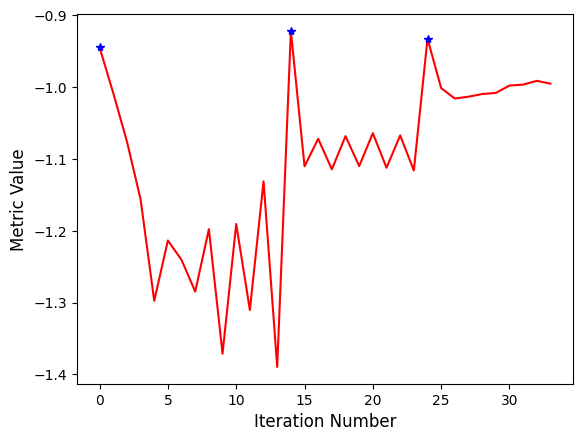

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 10.
Final metric value: -0.9907690841200933


In [5]:
# mattes 

registration_method = sitk.ImageRegistrationMethod()
# change the metrics depending on your data
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0, numberOfIterations=1000
)  # , estimateLearningRate=registration_method.EachIteration)
registration_method.SetOptimizerScalesFromPhysicalShift()

final_transform = sitk.Euler3DTransform(initial_transform)
registration_method.SetInitialTransform(final_transform)
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.AddCommand(
    sitk.sitkStartEvent, registration_callbacks.metric_start_plot
)
registration_method.AddCommand(
    sitk.sitkEndEvent, registration_callbacks.metric_end_plot
)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent,
    registration_callbacks.metric_update_multires_iterations,
)
registration_method.AddCommand(
    sitk.sitkIterationEvent,
    lambda: registration_callbacks.metric_plot_values(registration_method),
)

registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)
print(
f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)
print(f"Final metric value: {registration_method.GetMetricValue()}")



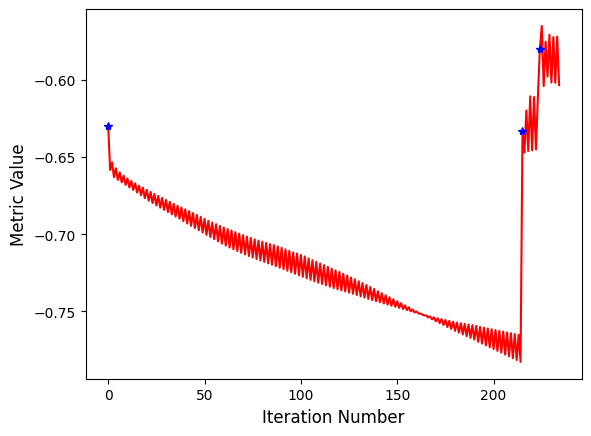

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 11.
Final metric value: -0.5723728145218009


In [11]:

# correlation 

registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsCorrelation()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(
    learningRate=0.1, numberOfIterations=1000
)  # , estimateLearningRate=registration_method.EachIteration)
#registration_method.SetOptimizerScalesFromPhysicalShift()

final_transform = sitk.Euler3DTransform(initial_transform)
registration_method.SetInitialTransform(final_transform)
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# plot the convergence 

registration_method.AddCommand(
    sitk.sitkStartEvent, registration_callbacks.metric_start_plot
)
registration_method.AddCommand(
    sitk.sitkEndEvent, registration_callbacks.metric_end_plot
)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent,
    registration_callbacks.metric_update_multires_iterations,
)
registration_method.AddCommand(
    sitk.sitkIterationEvent,
    lambda: registration_callbacks.metric_plot_values(registration_method),
)

registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)
print(
f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)
print(f"Final metric value: {registration_method.GetMetricValue()}")

In [12]:
print(
    f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)
print(f"Final metric value: {registration_method.GetMetricValue()}")


Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 11.
Final metric value: -0.5723728145218009


In [13]:
# substract images 
resampled = save_transform_and_image(
    final_transform,
    fixed_image,
    moving_image,
    os.path.join(OUTPUT_DIR_TEST, "18_registered_cor"),
    os.path.join(OUTPUT_DIR_TEST, "18_registered_cor")
)
difference_image_abs = sitk.Abs(sitk.Subtract(fixed_image, resampled))
difference_image = sitk.Subtract(fixed_image, resampled)
sitk.WriteImage(difference_image_abs, os.path.join(OUTPUT_DIR_TEST, '18_subtracted_abs_cor.nii.gz'))
sitk.WriteImage(difference_image, os.path.join(OUTPUT_DIR_TEST, '18_subtracted_cor.nii.gz'))



Look at the final transformation, what type is it? Why is it different from the previous example?

### Proces the whole dataset

<ul>
<li> Multi scale - specify both scale, and how much to smooth with respect to original image.</li>
<li> Initial transformation modified in place, so in the end we have the same type of transformation in hand.</li>
</ul>

In [ ]:
# execute registration for the whole dataset 
from registration_utilities import initial_alignment, apply_registration_mattesmutal, extract_prefix, apply_registration_correlation
import time 
start_time = time.time()
for preop_scan in preop:
    postop_scan = preop_scan.replace('preop', 'postop')
    if os.path.exists(postop_scan):
        fixed_image, moving_image = sitk.ReadImage(preop_scan), sitk.ReadImage(postop_scan)
        initial_transform = initial_alignment(fixed_image, moving_image)
        # try different similarity functions and check which one works the best 
        final_transform = apply_registration_correlation(initial_transform, fixed_image, moving_image)
        os.makedirs(os.path.join(OUTPUT_DIR + '/transforms'), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_DIR + '/images'), exist_ok=True)
        resampled_img = save_transform_and_image(
        final_transform,
        fixed_image,
        moving_image,
        # create separate directories to store transforms and images
        os.path.join(OUTPUT_DIR + '/transforms', extract_prefix(os.path.basename(preop_scan)) + '_registered'),
        os.path.join(OUTPUT_DIR + '/images', extract_prefix(os.path.basename(preop_scan)) + '_registered'),

    )
    else:

        print(f"Could not find the scan {preop_scan}..")


end_time = time.time()
duration = end_time - start_time
print(f"Registration took {duration} seconds to complete.")

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 167.
Final metric value: -0.3691865387098745
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 516.
Final metric value: -0.25689493089284854
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 422.
Final metric value: -0.33459578612330326
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value: -0.4353790615696437
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 14.
Final metric value: -0.5153874292417602
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value: -0.29761285622489625
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence chec

KeyboardInterrupt: 